In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df.sort_values(by="pchembl_value",ascending=True)
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
508,Cc1ccc(-c2[nH]cnc2C)cc1NC(=O)c1ccc(OCc2ccccn2)cc1,4.00,398.466,4.91984,0.483089
972,Cc1ccc(-c2ncc(C)n2C)cc1NC(=O)c1ccc(OCc2ccccn2)cc1,4.00,412.493,4.93024,0.487502
275,Cc1ccc(-c2cn(C)c(C)n2)cc1NC(=O)c1ccc(OCc2ccccn...,4.00,412.493,4.93024,0.487502
53,Cc1ccc(-c2cc(C(F)(F)F)[nH]n2)cc1NC(=O)c1ccc(OC...,4.00,452.436,5.63022,0.397406
553,Cc1ccc(-c2c(C)nn(C)c2C)cc1NC(=O)c1ccc(OCc2cccc...,4.00,426.520,5.23866,0.457838
...,...,...,...,...,...
213,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCNCC3)cc2N1c1c(...,10.00,504.820,7.28120,0.393491
1216,CNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3cc(NC(=O)c4ccc...,10.00,529.518,5.78900,0.305571
1268,Cc1ccc2c(=NC3CC3)[nH]oc2c1-c1ccc2c(c1)NC(=O)C2...,10.22,423.463,5.19862,0.594894
1323,Cc1ccc(C(=O)N=c2cco[nH]2)cc1-c1ccc2c(c1)NC(=O)...,10.22,403.438,3.32452,0.685953


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("pchembl_sorted_fcv_results_RF_training batches.csv", index=False)
    test_df.to_csv("pchembl_sorted_fcv_results_RF_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.15174757200829606, pvalue=0.06942717968592323)
PearsonRResult(statistic=0.1023356412895708, pvalue=0.22226323111820762)
PearsonRResult(statistic=0.1314425871502237, pvalue=0.11632545325098925)
PearsonRResult(statistic=0.03665733546167453, pvalue=0.6626909919281813)
PearsonRResult(statistic=-0.1431381466441209, pvalue=0.08698657870686007)
PearsonRResult(statistic=0.025444466577270793, pvalue=0.7621021047305765)
PearsonRResult(statistic=-0.09664901176311974, pvalue=0.24916491198427604)
PearsonRResult(statistic=-0.04233251722408644, pvalue=0.6144098073733385)
PearsonRResult(statistic=-0.08888718225668363, pvalue=0.281031966688628)


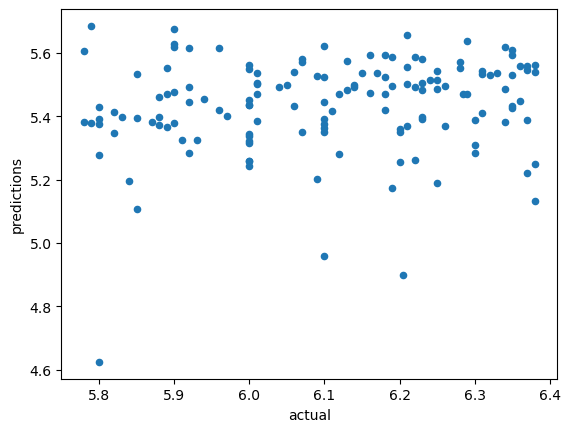

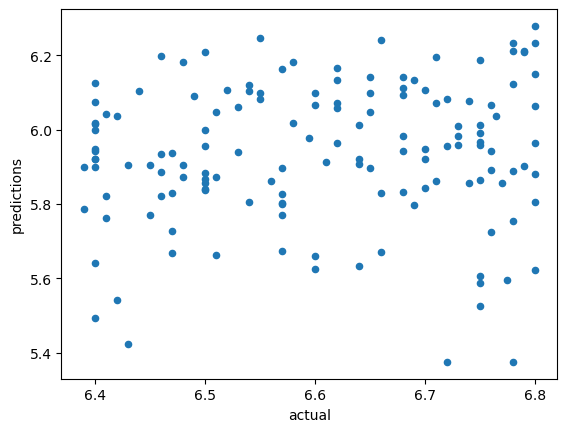

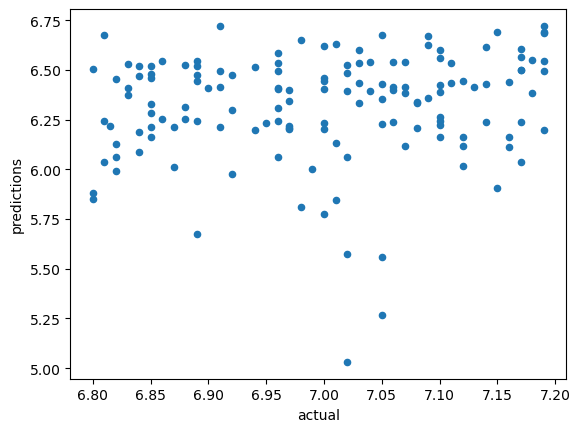

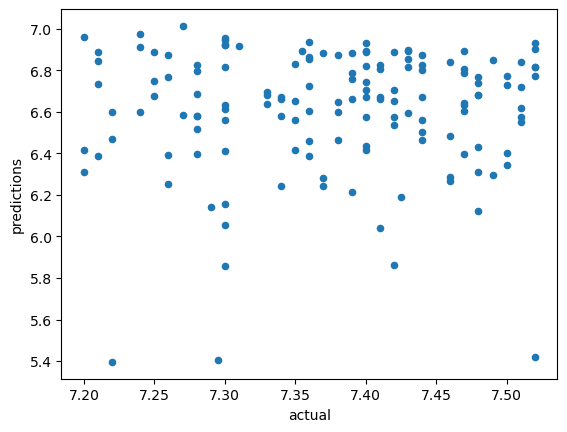

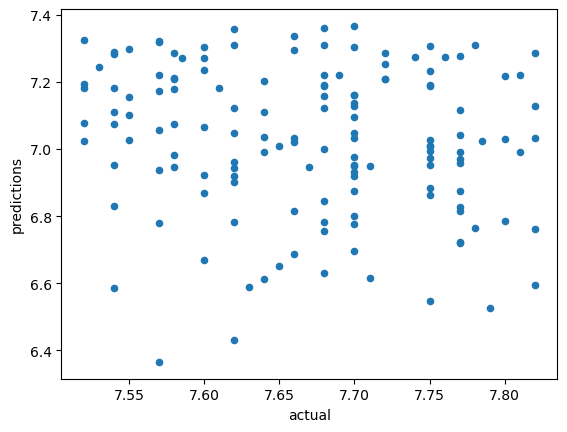

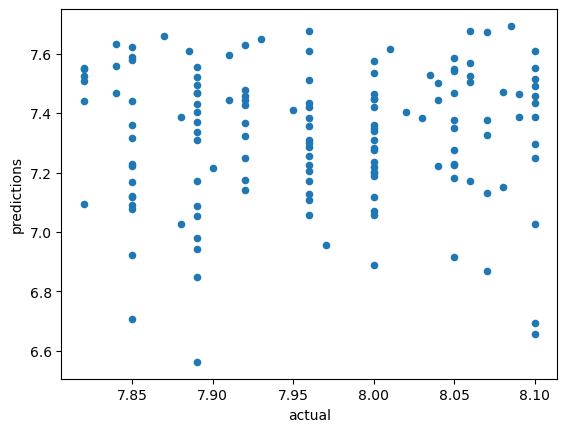

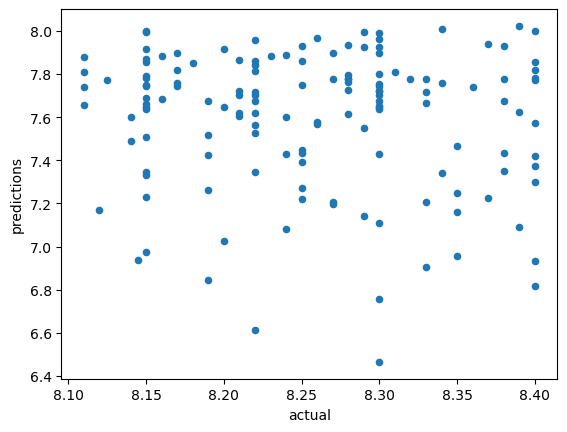

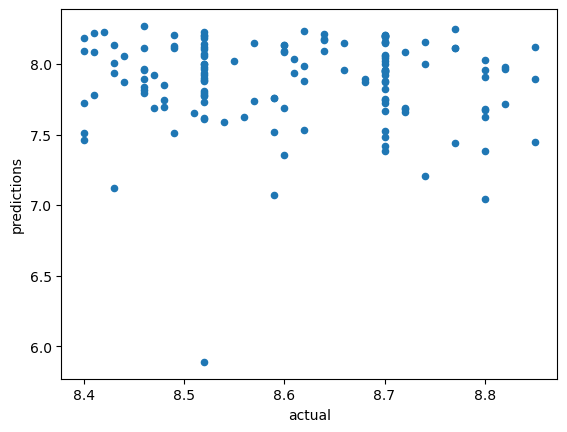

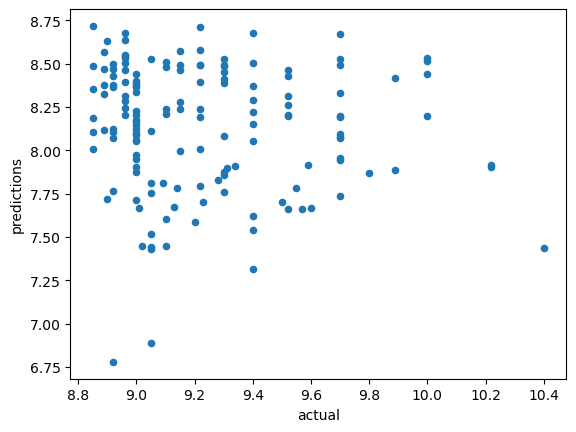

In [6]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [7]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [8]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(8, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [9]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(136, 3)
(144, 3)
(143, 3)
(144, 3)
(144, 3)
(144, 3)
(144, 3)
(144, 3)
(149, 3)


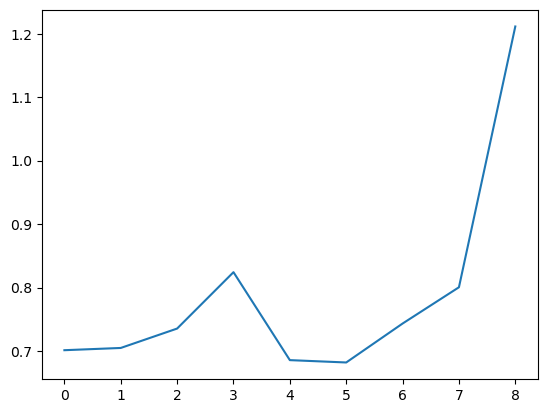

[0.7011246925706356, 0.7046657456407056, 0.7352538910879971, 0.8241722298687837, 0.6854719252294567, 0.6817684891352618, 0.7431637654593146, 0.8003768784141628, 1.211611419423675]


In [11]:
plt.plot(rmse)
plt.show()
print(rmse)

In [12]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

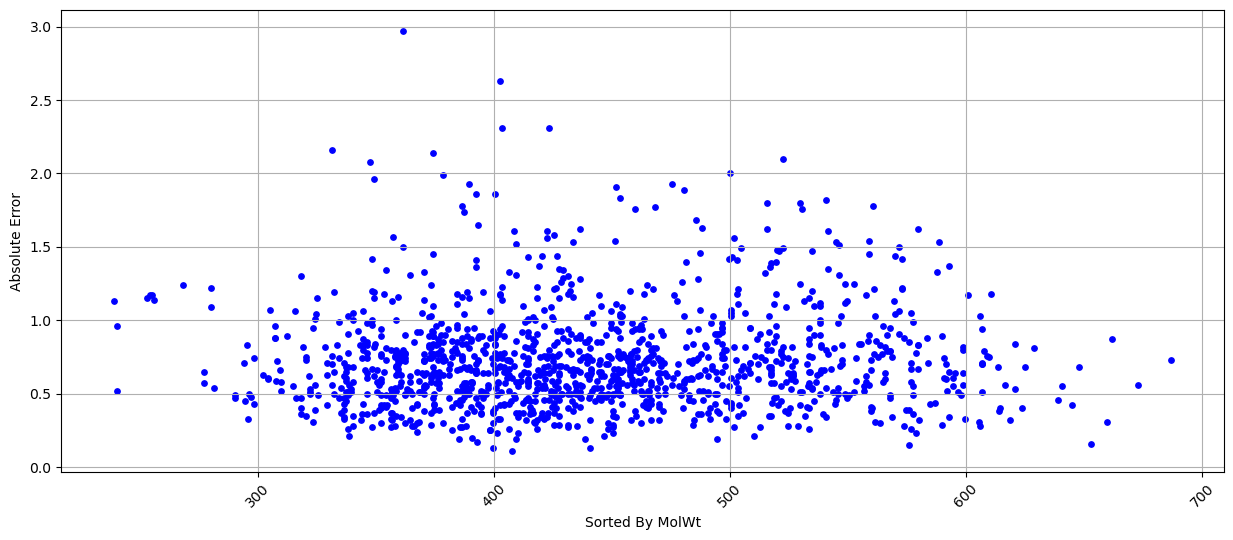

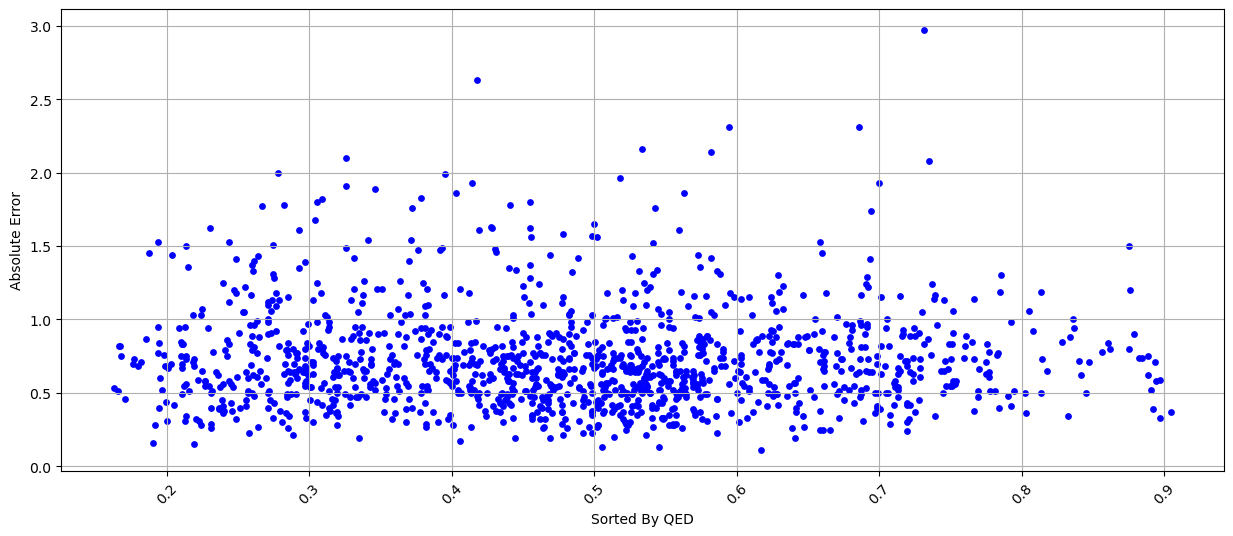

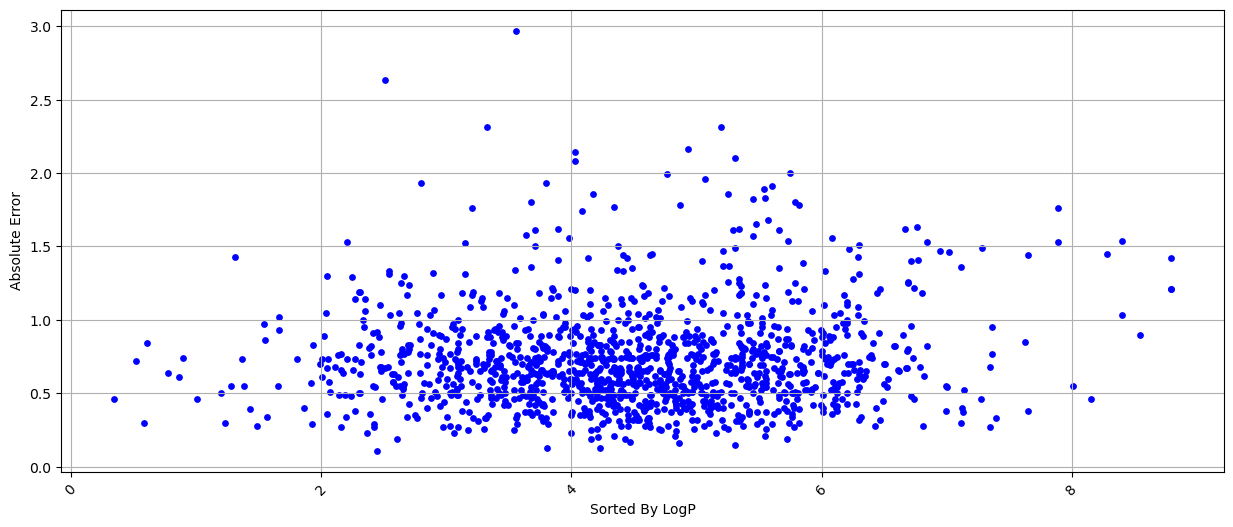

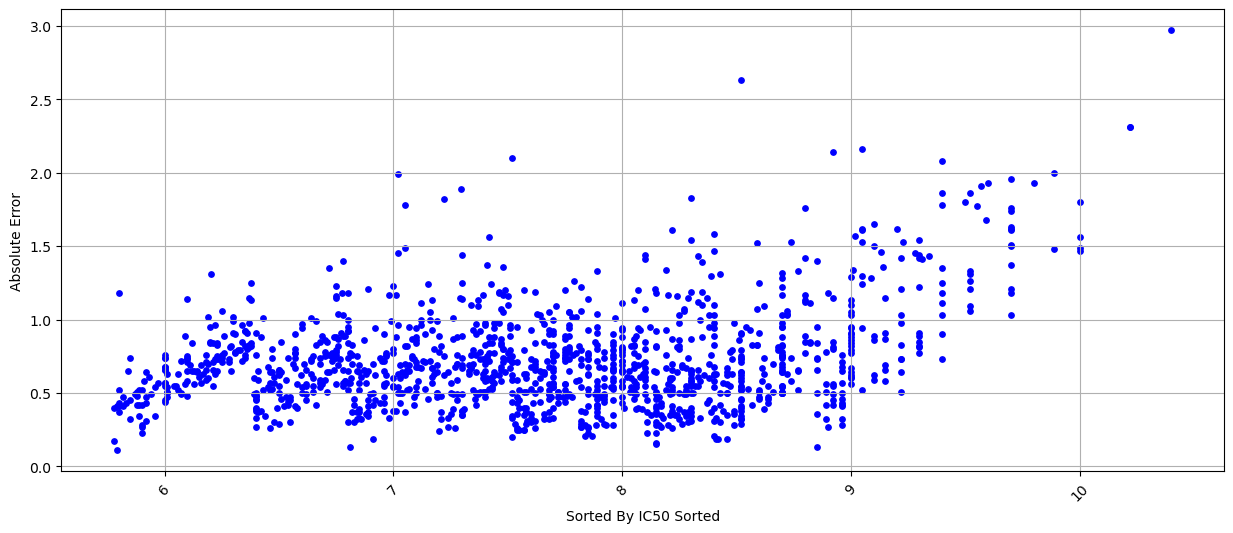

In [13]:
plot_graphs(df, results_df)

In [14]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
508,Cc1ccc(-c2[nH]cnc2C)cc1NC(=O)c1ccc(OCc2ccccn2)cc1,4.00,398.466,4.91984,0.483089,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
972,Cc1ccc(-c2ncc(C)n2C)cc1NC(=O)c1ccc(OCc2ccccn2)cc1,4.00,412.493,4.93024,0.487502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
275,Cc1ccc(-c2cn(C)c(C)n2)cc1NC(=O)c1ccc(OCc2ccccn...,4.00,412.493,4.93024,0.487502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
53,Cc1ccc(-c2cc(C(F)(F)F)[nH]n2)cc1NC(=O)c1ccc(OC...,4.00,452.436,5.63022,0.397406,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
553,Cc1ccc(-c2c(C)nn(C)c2C)cc1NC(=O)c1ccc(OCc2cccc...,4.00,426.520,5.23866,0.457838,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
213,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCNCC3)cc2N1c1c(...,10.00,504.820,7.28120,0.393491,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1216,CNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3cc(NC(=O)c4ccc...,10.00,529.518,5.78900,0.305571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1268,Cc1ccc2c(=NC3CC3)[nH]oc2c1-c1ccc2c(c1)NC(=O)C2...,10.22,423.463,5.19862,0.594894,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1323,Cc1ccc(C(=O)N=c2cco[nH]2)cc1-c1ccc2c(c1)NC(=O)...,10.22,403.438,3.32452,0.685953,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("pchembl_sorted_fcv_results_RF_training batches_druglike.csv", index=False)
    test_df.to_csv("pchembl_sorted_fcv_results_RF_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.16258386001797523, pvalue=0.05153749205703464)
PearsonRResult(statistic=0.10471255793992754, pvalue=0.2116518568834661)
PearsonRResult(statistic=0.039121901328495245, pvalue=0.6415379646263474)
PearsonRResult(statistic=0.1892568145114092, pvalue=0.023094938410458656)
PearsonRResult(statistic=0.17070947677618803, pvalue=0.04078576603607384)
PearsonRResult(statistic=0.03511793869692329, pvalue=0.676041149623572)
PearsonRResult(statistic=-0.055773868736425106, pvalue=0.5067092489697458)
PearsonRResult(statistic=-0.02411323550268626, pvalue=0.7742052298355864)
PearsonRResult(statistic=-0.06522181278071451, pvalue=0.43735468995280063)


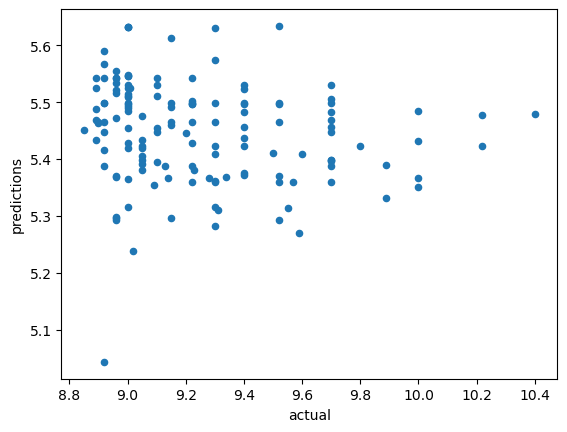

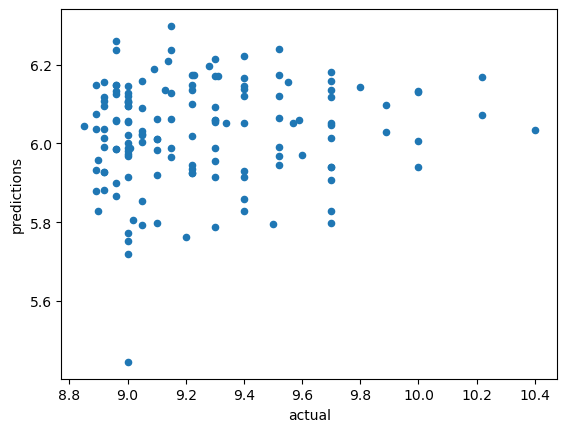

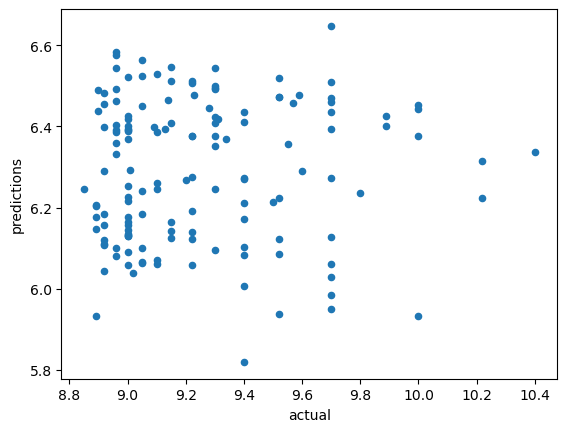

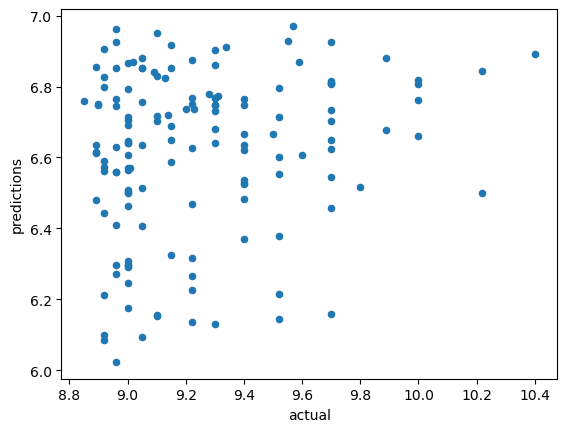

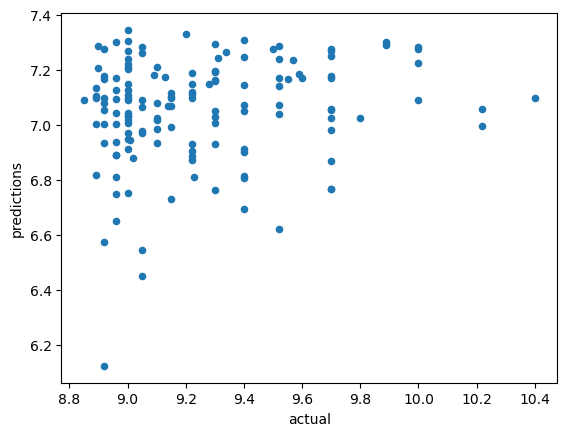

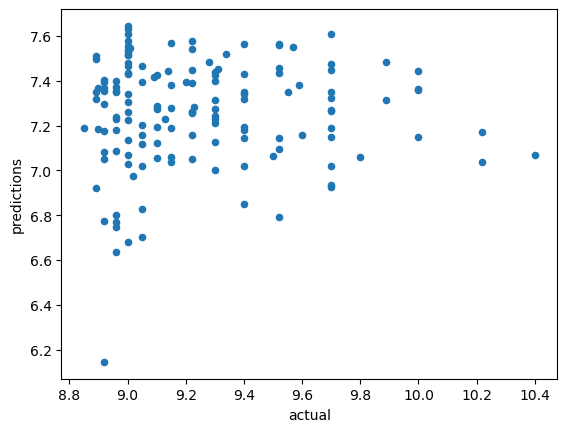

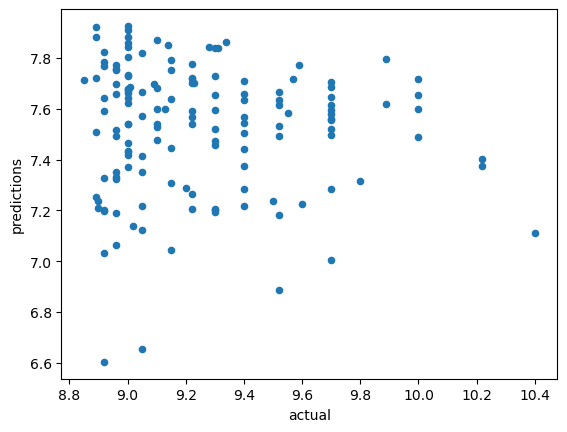

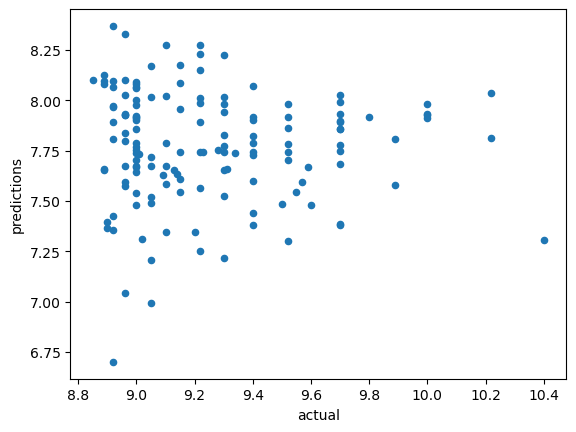

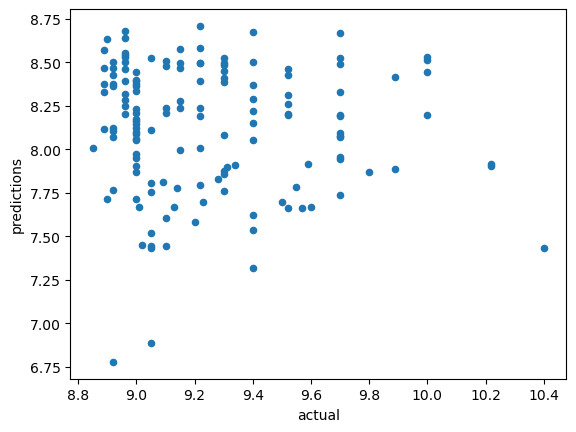

In [16]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [17]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [18]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(1, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [19]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(143, 3)
(144, 3)
(144, 3)
(144, 3)
(144, 3)
(144, 3)
(144, 3)
(144, 3)
(144, 3)


In [20]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


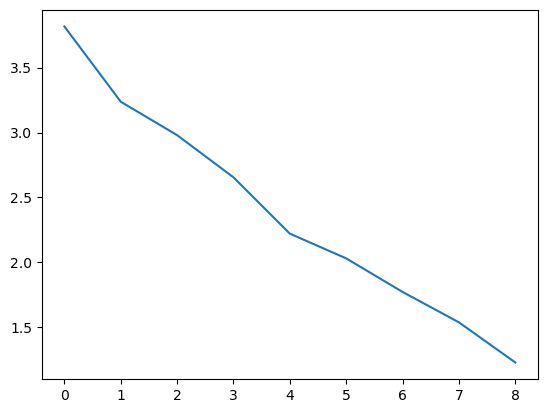

[3.8169576910970604, 3.2372977518029353, 2.9797528628207215, 2.654762425063427, 2.2210316820117626, 2.030404990047826, 1.771921203414845, 1.5376638262312083, 1.2285512729543597]


In [21]:
plt.plot(rmse)
plt.show()
print(rmse)

In [22]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
508,Cc1ccc(-c2[nH]cnc2C)cc1NC(=O)c1ccc(OCc2ccccn2)cc1,4.00,398.466,4.91984,0.483089,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
972,Cc1ccc(-c2ncc(C)n2C)cc1NC(=O)c1ccc(OCc2ccccn2)cc1,4.00,412.493,4.93024,0.487502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
275,Cc1ccc(-c2cn(C)c(C)n2)cc1NC(=O)c1ccc(OCc2ccccn...,4.00,412.493,4.93024,0.487502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
53,Cc1ccc(-c2cc(C(F)(F)F)[nH]n2)cc1NC(=O)c1ccc(OC...,4.00,452.436,5.63022,0.397406,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
553,Cc1ccc(-c2c(C)nn(C)c2C)cc1NC(=O)c1ccc(OCc2cccc...,4.00,426.520,5.23866,0.457838,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
213,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCNCC3)cc2N1c1c(...,10.00,504.820,7.28120,0.393491,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1216,CNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3cc(NC(=O)c4ccc...,10.00,529.518,5.78900,0.305571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1268,Cc1ccc2c(=NC3CC3)[nH]oc2c1-c1ccc2c(c1)NC(=O)C2...,10.22,423.463,5.19862,0.594894,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1323,Cc1ccc(C(=O)N=c2cco[nH]2)cc1-c1ccc2c(c1)NC(=O)...,10.22,403.438,3.32452,0.685953,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
